In [3]:
#!/usr/bin/env python

from iminuit import Minuit
import optimistix as optx

import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax.scipy import optimize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TriplePandelSPE/JAX stuff
from lib.simdata_i3 import I3SimHandlerFtr
from lib.geo import center_track_pos_and_time_based_on_data
from lib.network import get_network_eval_v_fn
from dom_track_eval import get_eval_network_doms_and_track
from likelihood_spe import get_neg_c_triple_gamma_llh
from likelihood_spe import get_llh_and_grad_fs_for_iminuit_migrad

from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

# Number of scan points on 1D
n_eval = 50 # making it a 100x100 grid

# Scan range (truth +/- dzen, +/- dazi)
dzen = 0.03 # rad
dazi = 0.03 # rad

In [88]:
# Event Index.
event_index = 3

# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("shifted seed vertex:", centered_track_pos)

# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

muon energy: 2.2 TeV
n_doms 58
original seed vertex: [ 1180.18566012 -1499.16735802  -782.32800156]
shifted seed vertex: [-38.65768538 207.2454018  145.80801123]


In [89]:
# Combine into single data tensor for fitting.
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time']].to_numpy())

obj_fn, obj_grad = get_llh_and_grad_fs_for_iminuit_migrad(eval_network_doms_and_track)

# put the thing below into a for loop if you want to reconstruct many events (without jit-recompiling everything)
f_prime = lambda x: obj_fn(x, centered_track_time, fitting_event_data)
grad_prime = lambda x: obj_grad(x, centered_track_time, fitting_event_data)

x0 = jnp.concatenate([track_src, centered_track_pos])
m = Minuit(f_prime, x0, grad=grad_prime)
m.errordef = Minuit.LIKELIHOOD
m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
m.strategy = 0
m.migrad()

print("... solution found.")
print(f"-2*logl={m.fval:.3f}")
print(f"zenith={m.values[0]:.3f}rad")
print(f"azimuth={m.values[1]:.3f}rad")
print(f"x={m.values[2]:.3f}m")
print(f"y={m.values[3]:.3f}m")
print(f"z={m.values[4]:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")


... solution found.
-2*logl=737.833
zenith=1.990rad
azimuth=5.346rad
x=-38.957m
y=209.023m
z=145.781m
at fix time t=12375.863ns


In [90]:
# Setup likelihood
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)

scale = 20.0
@jax.jit
def neg_llh_5D(x, args):
        zenith = x[0] / scale
        azimuth = x[1] / scale
        zenith = jnp.fmod(zenith, 2.0*jnp.pi)
        zenith = jnp.where(zenith < 0, zenith+2.0*jnp.pi, zenith)
        cond = zenith > jnp.pi
        zenith = jnp.where(cond, -1.0*zenith+2.0*jnp.pi, zenith)
        azimuth = jnp.where(cond, azimuth-jnp.pi, azimuth)

        azimuth = jnp.fmod(azimuth, 2.0*jnp.pi)
        azimuth = jnp.where(azimuth < 0, azimuth+2.0*jnp.pi, azimuth)
        
        projected_dir = jnp.array([zenith, azimuth])
        return neg_llh(projected_dir, x[2:]*scale, centered_track_time, fitting_event_data)




In [91]:
solver = optx.BFGS(rtol=1e-6, atol=1e-3)
x0 = jnp.concatenate([track_src*scale, centered_track_pos/scale])
result = optx.minimise(neg_llh_5D, solver, x0)

In [92]:
new_result = jnp.concatenate([result.value[:2]/scale, result.value[2:]*scale])

In [93]:
print(neg_llh_5D(result.value, None), new_result)

737.8326836380895 [  1.99013463   5.34617995 -38.97426534 209.02941248 145.77736706]


In [94]:
%timeit optx.minimise(neg_llh_5D, solver, x0)

118 ms ± 27.3 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [95]:
import equinox as eqx

In [96]:
def run(x):
    return optx.minimise(neg_llh_5D, solver, x).value

In [97]:
#run_many = eqx.filter_vmap(run)
run_many = jax.jit(jax.vmap(run, 0, 0))

In [98]:
x0_m = jnp.repeat(x0.reshape((1, x0.shape[0])), 10, axis=0)
print(x0_m.shape)
print(run_many(x0_m))

(10, 5)
[[ 39.80269255 106.92359893  -1.94871327  10.45147062   7.28886835]
 [ 39.80269255 106.92359893  -1.94871327  10.45147062   7.28886835]
 [ 39.80269255 106.92359893  -1.94871327  10.45147062   7.28886835]
 [ 39.80269255 106.92359893  -1.94871327  10.45147062   7.28886835]
 [ 39.80269255 106.92359893  -1.94871327  10.45147062   7.28886835]
 [ 39.80269255 106.92359893  -1.94871327  10.45147062   7.28886835]
 [ 39.80269255 106.92359893  -1.94871327  10.45147062   7.28886835]
 [ 39.80269255 106.92359893  -1.94871327  10.45147062   7.28886835]
 [ 39.80269255 106.92359893  -1.94871327  10.45147062   7.28886835]
 [ 39.80269255 106.92359893  -1.94871327  10.45147062   7.28886835]]


In [99]:
%timeit run_many(x0_m)

236 ms ± 77.7 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
@jax.jit
def neg_llh_3D(x, track_dir):
    return neg_llh(track_dir, x*scale, centered_track_time, fitting_event_data)

def run_3D(track_dir):
    x0 = jnp.array(centered_track_pos/scale)
    values = optx.minimise(neg_llh_3D, solver, x0, args=track_dir).value
    return neg_llh_3D(values, track_dir)

run_3D_v = jax.jit(jax.vmap(run_3D, 0, 0))

In [101]:
run_3D(track_src)

Array(740.68839209, dtype=float64)

In [102]:
%timeit run_3D(track_src)

87.1 ms ± 79.5 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [111]:
n_eval = 30 # making it a 30x30 grid

# Scan range (truth +/- dzen, +/- dazi)
dzen = 0.03 # rad
dazi = 0.03 # rad

zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])

In [112]:
logls = run_3D_v(init_dirs)

In [113]:
%timeit run_3D_v(init_dirs)

8.94 s ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [118]:
import matplotlib.pyplot as plt

In [119]:
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

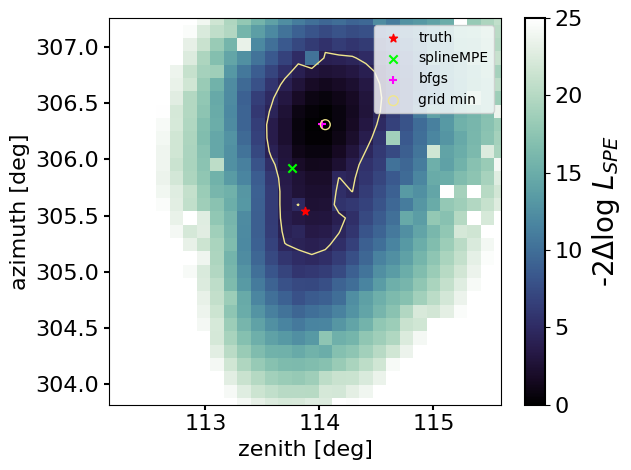

In [120]:
logls = logls.reshape(X.shape)


fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([25, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

zenith = new_result[0]
azimuth = new_result[1]
ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='+', color='magenta', label='bfgs')

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()

In [117]:
print(new_result)

[  1.99013463   5.34617995 -38.97426534 209.02941248 145.77736706]
